In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from io import open
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import time
# from scipy.stats import gaussian_kde
# import scipy.stats as stats

In [2]:
from dataset import Step2_DataSet
from time_series_models import GRUSeq2SeqWithAttention, TimeSeriesModel, SequenceDataset
# from sequence_dataset import SequenceDataset, train_test_split

In [3]:
import kgml_lib

In [4]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [5]:
# define functions from kgml_lib
Z_norm = kgml_lib.Z_norm 
Z_norm_reverse = kgml_lib.Z_norm_reverse
get_gpu_memory = kgml_lib.get_gpu_memory

In [6]:
root_dir = 'E:/PyKGML/deposit_code_v2/'
data_path = root_dir +  'processed_data/'
output_path = root_dir + 'test_results/'

input_data = 'recotest_data_scaled_v4_100sample.sav'
sample_index_file = "traindataset_split_year_v1.sav"

pretrained_model = "recotest_v11_exp4.sav_step1"
output_model = "recotest_v11_exp4_sample.sav_step2"
synthetic_data = "sys_data2.sav"

dataset = Step2_DataSet(data_path, input_data, output_path, sample_index_file)
dataset.load_step2_data()

dataset.prepare_step2_data()

torch.Size([6570, 100, 19]) torch.Size([6570, 100, 3]) torch.Size([18, 100, 1])
['RADN', 'TMAX_AIR', 'TDIF_AIR', 'HMAX_AIR', 'HDIF_AIR', 'WIND', 'PRECN', 'Crop_Type', 'GPP', 'Year', 'TBKDS', 'TSAND', 'TSILT', 'TFC', 'TWP', 'TKSat', 'TSOC', 'TPH', 'TCEC']


In [15]:
num_input_features = 19
num_output_features = 3

input_dim = num_input_features
hidden_dim = 128
num_layers = 3
output_dim = num_output_features
dropout=0.2

In [16]:
# Choose one of the models below:
#model = LSTMSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)
# model = GRUSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)

# model = EnhancedGRUModel(input_dim, hidden_dim, num_layers, output_dim)

# model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim)

In [17]:
X = dataset.X  #[365*18, 100, 19]
X = torch.transpose(X,1, 0) #[100, 365*18, 19]

Y1 = dataset.Y1 #[365*18, 100, 3]
Y1 = torch.transpose(Y1,1, 0) #[100, 365*18, 3]

Y2 = dataset.Y2 #[18, 100, 1]
Y2 = torch.transpose(Y2,1, 0)

total_years = 18
# days_per_year = 365
# total_days = total_years * days_per_year
# num_sites = X.shape[0] #100

batch_size=64

# Pickup last two years as test
# model.train_test_split(X, Y1, total_years, batch_size)

# Random pickup 20% sites as test
model.train_test_split(X, Y1, total_years, batch_size, split_method=1)

In [18]:
learning_rate = 0.001
step_size = 20
max_epoch = 60
loss_function = nn.L1Loss()

# model.train_model(train_loader, test_loader, LR= learning_rate, step_size=20, gamma=0.8, maxepoch=60)
model.train_model(loss_fun=loss_function, LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/60 | LR: 0.001000, Train Loss: 0.6394, Test Loss: 0.5001
Epoch 2/60 | LR: 0.001000, Train Loss: 0.4753, Test Loss: 0.4216
Epoch 3/60 | LR: 0.001000, Train Loss: 0.3782, Test Loss: 0.3236
Epoch 4/60 | LR: 0.001000, Train Loss: 0.3026, Test Loss: 0.2797
Epoch 5/60 | LR: 0.001000, Train Loss: 0.2611, Test Loss: 0.2467
Epoch 6/60 | LR: 0.001000, Train Loss: 0.2393, Test Loss: 0.2291
Epoch 7/60 | LR: 0.001000, Train Loss: 0.2199, Test Loss: 0.2163
Epoch 8/60 | LR: 0.001000, Train Loss: 0.2060, Test Loss: 0.2118
Epoch 9/60 | LR: 0.001000, Train Loss: 0.1944, Test Loss: 0.1993
Epoch 10/60 | LR: 0.001000, Train Loss: 0.1862, Test Loss: 0.1950
Epoch 11/60 | LR: 0.001000, Train Loss: 0.1805, Test Loss: 0.1958
Epoch 12/60 | LR: 0.001000, Train Loss: 0.1737, Test Loss: 0.1824
Epoch 13/60 | LR: 0.001000, Train Loss: 0.1690, Test Loss: 0.1821
Epoch 14/60 | LR: 0.001000, Train Loss: 0.1648, Test Loss: 0.1778
Epoch 15/60 | LR: 0.001000, Train Loss: 0.1607, Test Loss: 0.1815
Epoch 16/60 | LR: 0

In [19]:
# model.test(test_loader)
model.test()

Test Loss: 0.1701


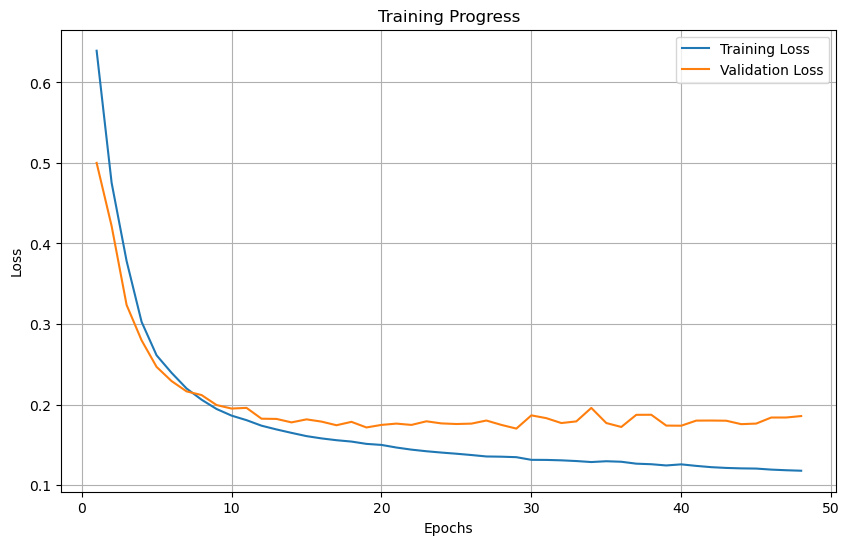

In [20]:
model.plot_training_curves()

In [21]:
y_scaler = dataset.Y1_scaler
output_feature_name = ['Ra','Rh','NEE']
model.get_R2_score(y_scaler, output_feature_name)

Feature Ra R2 Score is: 0.9428732518483388
Feature Rh R2 Score is: 0.7986460879587529
Feature NEE R2 Score is: 0.9313807262088036


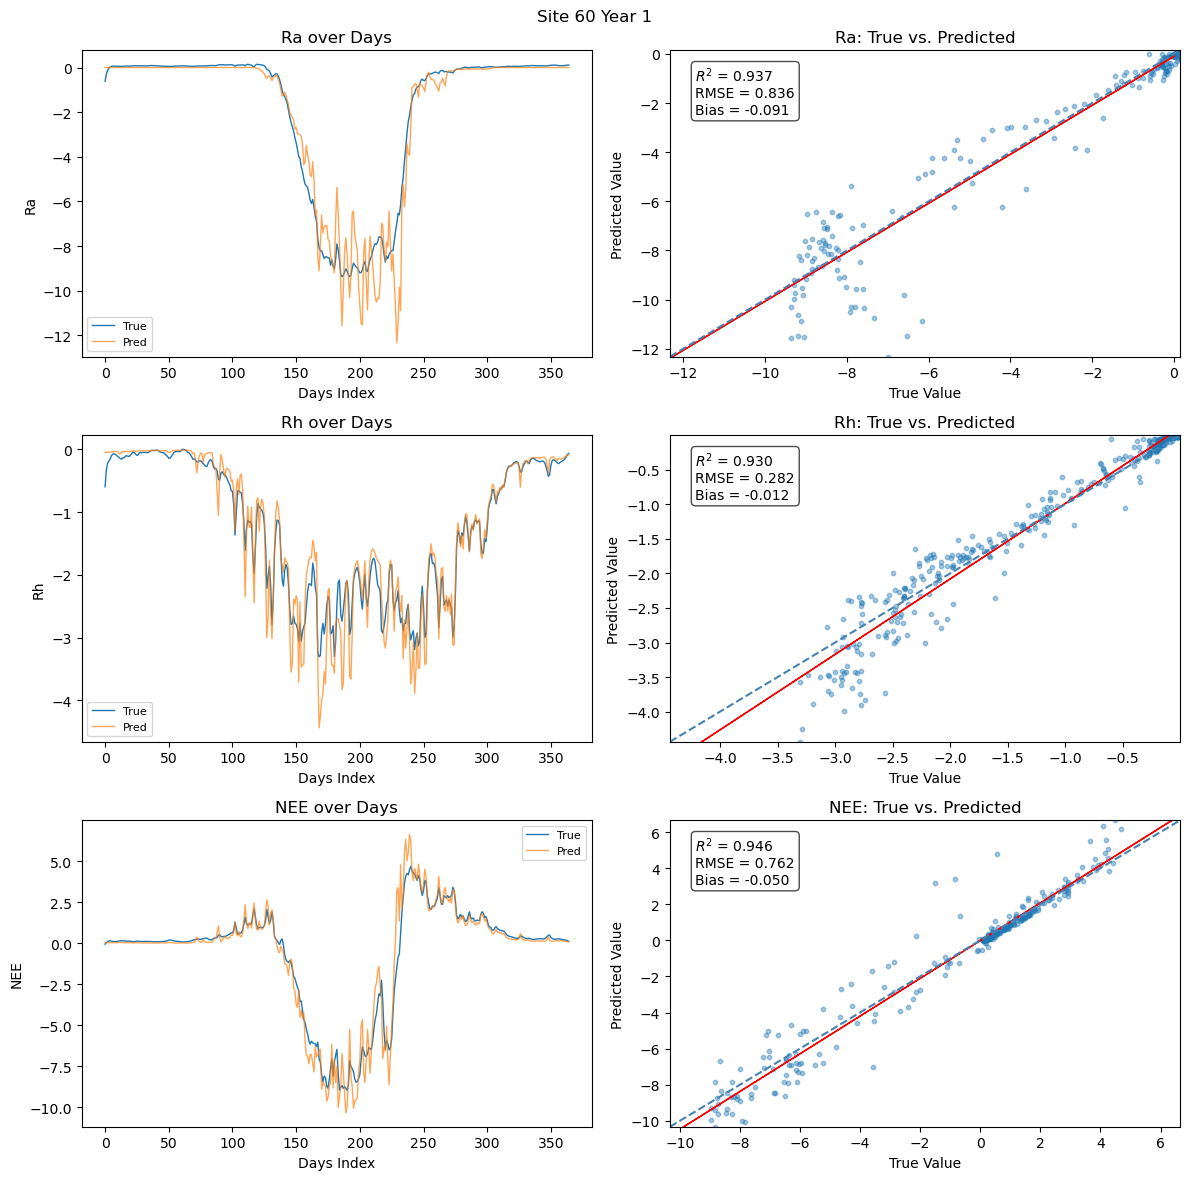

In [22]:
model.Vis_prediction_result(y_scaler, output_feature_name, 60, 1)